# LP für gemischt-ganzzahlige Optimierungsprobleme (MILP)
(Mixed-Integer Linear Program)

**HiGHS**

- Exakter Solver (Branch-and-Bound)
- HiGHS löst dein MILP per Simplex/Barrier‐Verfahren plus Branch-and-Bound.
- Wenn der Solver bis zum Time‐Limit läuft, liefert er eine (provably) optimale oder zumindest pareto‐optimale Lösung mit einer nachgewiesenen Lücke (Optimality Gap).

## II) Minimierung der Summe aller Startzeiten unter Fixierung des Makespan

In [4]:
import pulp
import pandas as pd

def solve_stage2_early_starts_all(job_dict, df_arrivals, optimal_makespan, solver_time_limit=300, epsilon=0.06):
    """
    Zweite Stufe: Minimierung der Summe aller Startzeiten unter Fixierung des Makespan (verbesserte Version).

    Parameter:
    - job_dict: Dictionary der Jobs mit Maschinen- und Bearbeitungszeiten.
    - df_arrivals: DataFrame mit Ankunftszeiten der Jobs.
    - optimal_makespan: Optimales Makespan aus Stufe 1 (fester Endzeitpunkt).
    - solver_time_limit: Zeitlimit für den Solver (Sekunden).
    - epsilon: Kleiner Sicherheitsabstand zwischen Operationen auf derselben Maschine.
    """

    # Ankunftszeiten als Dictionary
    df_arrivals = df_arrivals.sort_values("Arrival").reset_index(drop=True)
    arrival_times = df_arrivals.set_index("Job")["Arrival"].to_dict()

    # Jobnamen nach Ankunftszeit sortieren (absteigend)
    job_names = list(df_arrivals.sort_values("Arrival", ascending=False)["Job"])

    num_jobs = len(job_names)
    
    all_ops = [job_dict[job_name] for job_name in job_names]

    all_machines = {op[0] for job in all_ops for op in job}

    prob = pulp.LpProblem("JobShop_Secondary_EarlyStart", pulp.LpMinimize)

    # Startzeit-Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Ankunftszeiten vorbereiten
    #arrival_times = df_arrivals.set_index("Job")["Arrival"].to_dict()

    # Technologische Reihenfolge und Ankunftszeiten einfügen
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (mit epsilon Abstand)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Fixierter Makespan: Endzeit der letzten Operationen darf den optimalen Makespan nicht überschreiten
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += starts[(j, last_op)] + all_ops[j][last_op][1] <= optimal_makespan

    # ZIEL: Minimierung der Summe aller Startzeiten (nicht nur der ersten Operationen)
    total_start = pulp.lpSum([starts[(j, o)] for j in range(num_jobs) for o in range(len(all_ops[j]))])
    prob += total_start

    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisse extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)

    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Flow Time"] = df_schedule["End"] - df_schedule["Arrival"]

    # Spaltenreihenfolge anpassen
    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow Time", "End"]]
    
    return df_schedule, optimal_makespan

### --------------------------------------------------------------------------

In [6]:
import sys, json
from pathlib import Path

# 1. Projekt-Root nur einmal bestimmen
PROJECT_ROOT = Path.cwd().parent.resolve()

# 2. sys.path fürs Importieren um PROJECT_ROOT erweitern
sys.path.insert(0, str(PROJECT_ROOT))

In [7]:
import pandas as pd
import utils.checker as check
import utils.presenter as show
import utils.schedule_interarrival as sit

In [8]:
data_file = Path(PROJECT_ROOT, "data/jobshop_instances.json")
# Datei laden
with open(data_file, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [9]:
u_b_mmax = 0.9  # 90% Auslastung (der Engpassmaschine)

mean_interarrival_time = sit.calculate_mean_interarrival_time(instance, u_b_mmax)
print(f"Mittlere Zwischenankunftszeit (bei Auslastung von {u_b_mmax:.0%}): {mean_interarrival_time} Minuten")
df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(instance, t_a=mean_interarrival_time)
df_arrivals

Mittlere Zwischenankunftszeit (bei Auslastung von 90%): 70.11 Minuten


,Job,Arrival
0,job 0,0.00
1,job 1,84.93
2,job 2,106.18
3,job 3,148.31
4,job 4,185.08
5,job 5,251.37
6,job 6,312.71
7,job 7,329.63
8,job 8,344.30
9,job 9,429.20


In [10]:
makespan = 1100.2      #  aus Notebook "11_LP für Makespan mit Ankunftszeiten"

In [11]:
df_schedule, makespan = solve_stage2_early_starts_all(instance, df_arrivals, makespan, solver_time_limit=600, epsilon=0)
df_schedule

,Job,Arrival,Machine,Start,Processing Time,Flow Time,End
0,job 9,429.2,M1,429.2,85,85.0,514.2
1,job 9,429.2,M0,543.3,13,127.1,556.3
2,job 9,429.2,M2,556.3,61,188.1,617.3
3,job 9,429.2,M6,622.0,7,199.8,629.0
4,job 9,429.2,M8,635.0,64,269.8,699.0
...,...,...,...,...,...,...,...
95,job 0,0.0,M5,201.0,11,212.0,212.0
96,job 0,0.0,M6,212.0,62,274.0,274.0
97,job 0,0.0,M7,274.0,56,330.0,330.0
98,job 0,0.0,M8,330.0,44,374.0,374.0


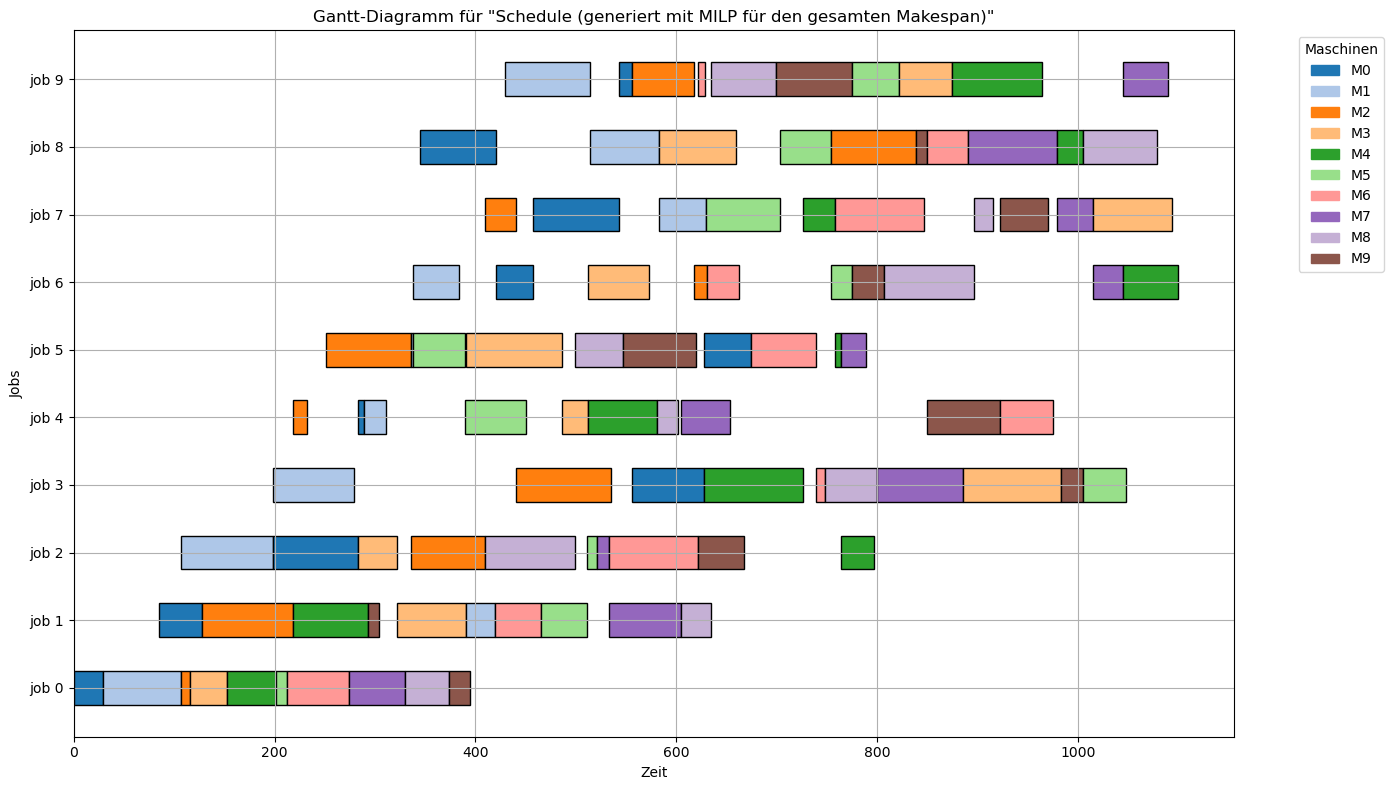

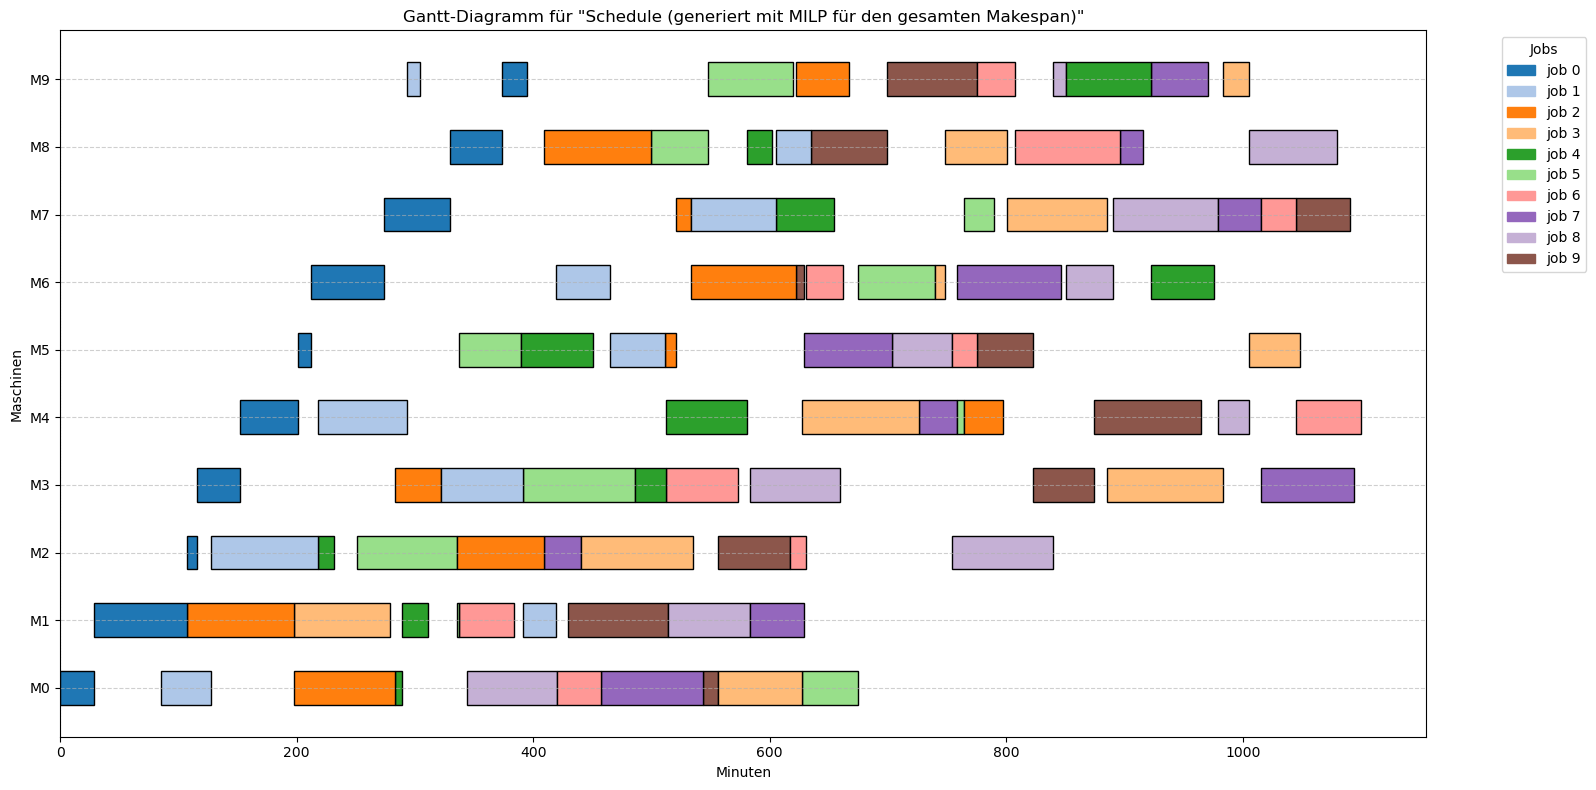

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [12]:
category = "Schedule (generiert mit MILP für den gesamten Makespan)"

show.plot_gantt_jobs(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule, instance)

In [13]:
print(f"Makespan: {makespan} Minuten")

Makespan: 1100.2 Minuten


> Solver-Dauer: 11.9s <br>Gap: 0.01%